# Circuit Breaker - Predictive Maintenance
## Schritt 1: Datensatz generieren

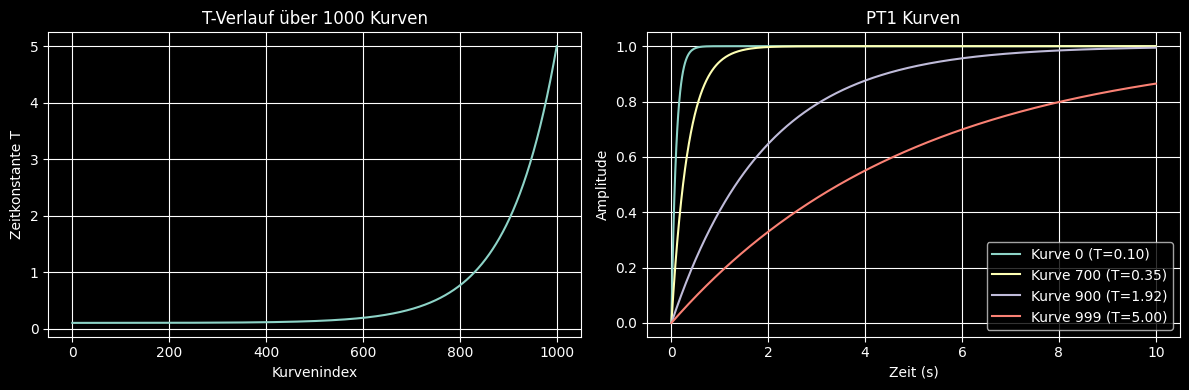

Dataset Shape: (1000, 500)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
n_curves = 1000
t = np.linspace(0, 10, 500)  # Zeitachse jeder PT1 Kurve

T_min = 0.1   # gesund
T_max = 5.0   # verschlissen
K = 1.0       # Verstärkung

# Normalisiertes T: lange nahe 0, dann schnell gegen 1
x = np.linspace(0, 1, n_curves)
steepness = 10
T_norm = (np.exp(steepness * x) - 1) / (np.exp(steepness) - 1)
T_values = T_min + T_norm * (T_max - T_min)

# 1000 PT1 Kurven generieren
dataset = np.zeros((n_curves, len(t)))
for i, T in enumerate(T_values):
    dataset[i] = K * (1 - np.exp(-t / T))

# Plot 1: T-Verlauf über die 1000 Kurven
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(T_values)
plt.title("T-Verlauf über 1000 Kurven")
plt.xlabel("Kurvenindex")
plt.ylabel("Zeitkonstante T")
plt.grid(True)

# Plot 2: Beispielkurven
plt.subplot(1, 2, 2)
for idx, label in [(0, "gesund"), (700, "mittel"), (900, "verschlissen"), (999, "defekt")]:
    plt.plot(t, dataset[idx], label=f"Kurve {idx} (T={T_values[idx]:.2f})")
plt.title("PT1 Kurven")
plt.xlabel("Zeit (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Dataset Shape: {dataset.shape}")

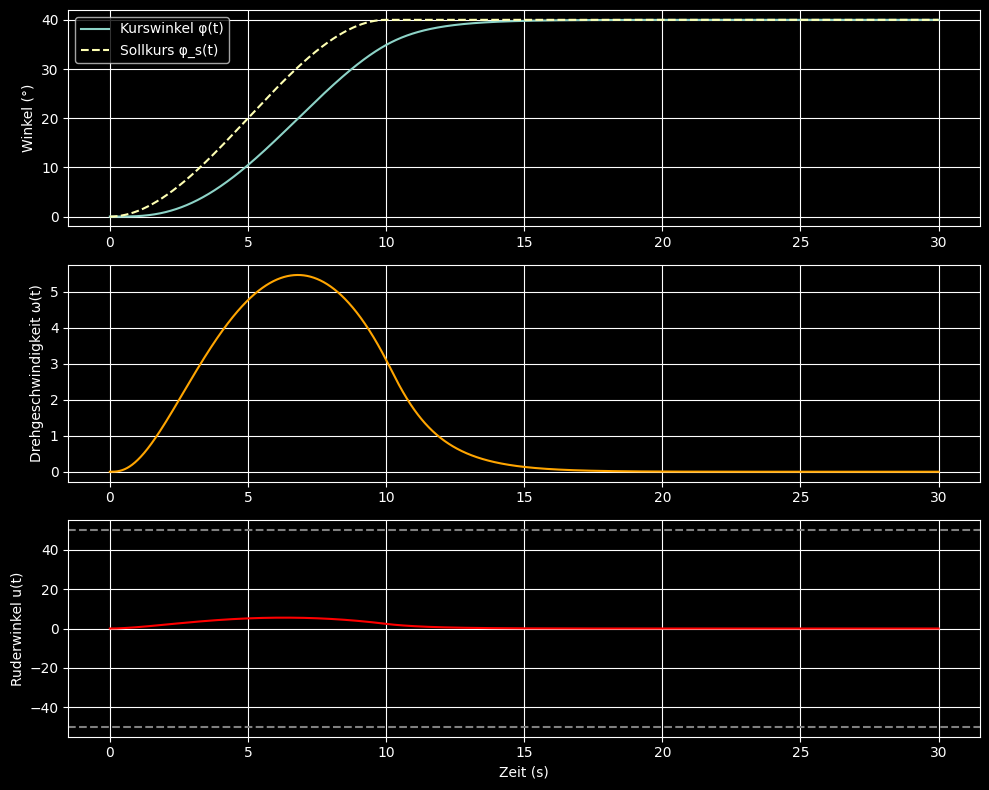

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameter
T1 = 0.5    # Zeitkonstante Schiff
V = 1.0     # Verstärkung (5/1 vereinfacht)
K = 0.9     # Regler P-Anteil
TD = 0.8    # Regler D-Anteil
u_max = 50  # Ruderbeschränkung in Grad
phi_s = 40  # Sollkurs in Grad
t1 = 10     # Zeit bis Sollkurs erreicht

# Sollkursverlauf
def phi_soll(t):
    if t <= t1:
        return phi_s * (3*(t/t1)**2 - 2*(t/t1)**3)
    else:
        return phi_s

# Ableitung des Sollkurses (für D-Anteil)
def phi_soll_dt(t, dt=1e-5):
    return (phi_soll(t + dt) - phi_soll(t - dt)) / (2 * dt)

# PD-Regler mit Begrenzung
def regler(phi, omega, t):
    u = K * (phi_soll(t) - phi) - K * TD * omega
    return np.clip(u, -u_max, u_max)

# Zustandsraumdarstellung: x = [phi, omega]
def system(t, x):
    phi, omega = x
    u = regler(phi, omega, t)
    dphi = omega
    # T1 * domega/dt + omega = V * u
    domega = (V * u - omega) / T1
    return [dphi, domega]

# Simulation
t_span = (0, 30)
t_eval = np.linspace(0, 30, 3000)
x0 = [0, 0]  # phi=0, omega=0

sol = solve_ivp(system, t_span, x0, t_eval=t_eval, max_step=0.01)

t = sol.t
phi = sol.y[0]
omega = sol.y[1]

# Sollkurs berechnen
phi_s_vec = np.array([phi_soll(ti) for ti in t])

# Ruderwinkel berechnen
u_vec = np.array([regler(phi[i], omega[i], t[i]) for i in range(len(t))])

# Plots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

axes[0].plot(t, phi, label="Kurswinkel φ(t)")
axes[0].plot(t, phi_s_vec, '--', label="Sollkurs φ_s(t)")
axes[0].set_ylabel("Winkel (°)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t, omega, color="orange")
axes[1].set_ylabel("Drehgeschwindigkeit ω(t)")
axes[1].grid(True)

axes[2].plot(t, u_vec, color="red")
axes[2].axhline(u_max, linestyle='--', color='gray')
axes[2].axhline(-u_max, linestyle='--', color='gray')
axes[2].set_ylabel("Ruderwinkel u(t)")
axes[2].set_xlabel("Zeit (s)")
axes[2].grid(True)

plt.tight_layout()
plt.show()